## Notebook to code up method of moments framework 

Here, I will use the method of moments framework used to track the trajectory of the site frequency spectrum through time given drift and selection from [Jouganous et. al. 2017](https://www.genetics.org/content/206/3/1549). Mostly, I will just use equations to start from a certain generation $t$ back in time and then iterate until generation 0. Then I will store this SFS as a data entry for allele age $t$ and certain selection coefficient $s$. This process will be repeated for each value of $\{1,\ldots,t,\ldots,12000\}$ generations. 

These vectors need to be summed to marginalize over *all* generations $a$, to give $P(X, a | s)$.

First, need to get a handle on what $\Phi_n^k(i)$ really is - can just be represented as *np.array*

$\phi_n^k(i)$ is the expected number of sites where the alternate allele is observed exactly $i$ times in a sample of size $n$ at generation $k$. 

In [236]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import numpy.ma as ma
import itertools as it
from copy import deepcopy

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['figure.dpi'] = 110
plt.rcParams.update({'figure.facecolor':'white'})

In [246]:
xx = ma.masked_array(range(11),mask=[True] + [False]*9 + [True])


8

In [307]:
N = 2500
s = 50/N # gamma = 100 - strong selection
mu = 1.25e-8 # human mutation rate
n = 20

mom = np.zeros(n+1)
momnp1 = np.zeros(n+1)
momkp1 = np.zeros(n+1)

# double precaution - creating a mask
mk = [False] + [True]*(n-1) + [False]

iter = np.arange(1,n)
iterm1p1 = np.arange(2,n-1)

# maskm1 = np.full(len(mom), 1)
# maskm1[n] = 0

# maskp1 = np.full(len(mom), 1)
# maskp1[0] = 0

In [16]:
## borrowed directly from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx
def python2round(f):
    if round(f + 1) - round(f) != 1:
        return f + abs(f) / f * 0.5
    return round(f)

# The choice i' in n samples that best approximates the frequency of i/(n + 1) is i*n / (n + 1)
def index_bis(i, n):
    return int(min(max(python2round(i * n / float(n+1)), 2), n-2))

In [18]:
# start in generation 10 so generation 11 has all zeros (going back in time)
t = 10
mom[1] = n*mu # singleton input
# going from generation 9 to 0
for gen in np.arange(t)[::-1]:
    drift1 = mom[iterm1] * iterm1 * (n - iterm1)/(n * (n - 1))
    drift2 = mom[iterp1] * iterp1 * (n - iterp1)/(n * (n - 1))
    drift3 = mom[iter] * 2 * iter * (n - iter)/(n * (n - 1))

    for i in np.arange(n):
        ibis = index_bis(i + 1, n) - 1
        
        alpha = 0.5 * (n+1) * (4 + i**2 * (6+5*n+n**2) - i * (14+9*n+n**2) - (n+4) * (2*i*(n+2)-n-5) * ibis + (n**2+7*n+12) * ibis**2) / (n+2) / (n+3) / (n+4)

        beta = (n+1) * ((i+1) * (n+2) * (i*(n+3)-n-6) - 2 * (n+4) * (i*(n+2)-1) * ibis + (n**2+7*n+12) * ibis**2) / (n+2) / (n+3) / (n+4)

        gamma = 0.5 * (n+1) * ((i+1) * (n+2) * (i*(n+3)-2) - (n+4) * (2*i*(n+2)+n+1) * ibis + (n**2+7*n+12) * ibis**2) / (n+2) / (n+3) / (n+4)

        momnp1[i] = alpha * mom[ibis-1] + beta * mom[ibis] + gamma * mom[ibis+1]

    selop = 0.5/(n + 1) * (iter * (n + 1 - iter) * momnp1[iter]) - (n - iter) * iterp1 * momnp1[iterp1]

    mom = mom + 0.25/N * n * (n - 1) * (drift1 + drift2 - drift3) + s * selop

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [105]:
## testbed for procudural code for drift operator - sequential
mom[1] = n*mu # singleton input
# mom = deepcopy(momkp1)
for i in np.arange(n+1):
    if i==0:
        momkp1[i] = 0.25/N * (mom[i+1] * (i+1)*(n-i-1) - mom[i] * 2*i*(n-i))
    elif i==n:
        momkp1[i] = 0.25/N * (mom[i-1] * (i-1)*(n-i+1) - mom[i] * 2*i*(n-i))
    else:
        momkp1[i] = 0.25/N * (mom[i-1] * (i-1)*(n-i+1) + mom[i+1] * (i+1)*(n-i-1) - mom[i] * 2*i*(n-i))
    
    momkp1[i] += mom[i]

In [82]:
print(mom)
print(momkp1)

[3.75002089e-09 2.42546799e-07 3.65681504e-09 4.58933097e-11
 4.68030856e-13 3.75640869e-15 2.26802417e-17 9.61092800e-20
 2.52684930e-22 3.07184597e-25 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[4.21085981e-09 2.41638286e-07 4.09155895e-09 5.85927275e-11
 6.96124114e-13 6.69565056e-15 5.04731535e-17 2.84876547e-19
 1.12243087e-21 2.72687767e-24 3.04112751e-27 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [294]:
## testbed for procedural code for drift operator - numpy broadcasting
# mom[1] = n*mu # singleton input
mom = deepcopy(momkp1)
momkp1[iterm1p1] = mom[iterm1p1] + 0.25/N * (mom[iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[iterm1p1] * 2*iterm1p1*(n-iterm1p1))

momkp1[1] = mom[1] + 0.25/N * ((n-2) * 2 * mom[2] - 2 * (n-1) * mom[1])
momkp1[n-1] = mom[n-1] + 0.25/N * ((n-2) * 2 * mom[n-2] - 2 * (n-1) * mom[n-1])

In [299]:
print(mom)
print(momkp1)
np.sum(mom[[False] + [True]*(n-1) + [False]])

[           nan 2.43435375e-07 1.84765081e-09 1.00007404e-11
 3.41946851e-14 5.51805307e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
            nan]
[           nan 2.42516973e-07 2.29692594e-09 1.65504946e-11
 8.47611829e-14 2.73198807e-16 4.13853980e-19 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
            nan]


2.4529306118530093e-07

In [208]:
## coding up the selection operator - for each i (only need to compute once)
# mom[1] = n*mu
mom = deepcopy(momkp1)
for i in np.arange(n+1):
    ibis = index_bis(i + 1, n) - 1
    
    alpha = 0.5 * (n+1) * (4 + i**2 * (6+5*n+n**2) - i * (14+9*n+n**2) - (n+4) * (2*i*(n+2)-n-5) * ibis + (n**2+7*n+12) * ibis**2) / (n+2) / (n+3) / (n+4)

    beta = (n+1) * ((i+1) * (n+2) * (i*(n+3)-n-6) - 2 * (n+4) * (i*(n+2)-1) * ibis + (n**2+7*n+12) * ibis**2) / (n+2) / (n+3) / (n+4)

    gamma = 0.5 * (n+1) * ((i+1) * (n+2) * (i*(n+3)-2) - (n+4) * (2*i*(n+2)+n+1) * ibis + (n**2+7*n+12) * ibis**2) / (n+2) / (n+3) / (n+4)

    momnp1[i] = alpha * mom[ibis-1] + beta * mom[ibis] + gamma * mom[ibis+1]

    momkp1[i] = s * (0.5/(n + 1) * (i * (n + 1 - i) * momnp1[i]) - (n - i) * (i + 1) * momnp1[i+1])

IndexError: index 21 is out of bounds for axis 0 with size 21

In [182]:
print(mom)
print(momkp1)

[ 7.46916507e-07  2.02811110e-07  6.38490378e-10  2.16182284e-12
  8.30774214e-15  3.50306322e-17  1.53134874e-19  6.42411718e-22
  2.32102370e-24  4.23448669e-26 -7.57003369e-27  3.46776336e-29
  9.96875462e-30  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
[ 8.28654218e-07  1.98110487e-07  6.82635193e-10  2.55426014e-12
  1.09967011e-14  5.30264760e-17  2.73702526e-19  1.42571413e-21
  6.92724763e-24  3.44710707e-25 -3.89100218e-26 -5.11391074e-28
  9.58214031e-29 -8.76173414e-31 -9.65353709e-32  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


In [213]:
## coding up the selection operator through broadcast
# compute alpha, beta, gamma once
alpha = beta = gamma = np.zeros(n+1)
# mom = deepcopy(momkp1)
for i in np.arange(n+1):
    ibis = index_bis(i + 1, n) 
    
    alpha[i] = 0.5 * (n+1) * (4 + i**2 * (6+5*n+n**2) - i * (14+9*n+n**2) - (n+4) * (2*i*(n+2)-n-5) * ibis + (n**2+7*n+12) * ibis**2) / (n+2) / (n+3) / (n+4)

    beta[i] = (n+1) * ((i+1) * (n+2) * (i*(n+3)-n-6) - 2 * (n+4) * (i*(n+2)-1) * ibis + (n**2+7*n+12) * ibis**2) / (n+2) / (n+3) / (n+4)

    gamma[i] = 0.5 * (n+1) * ((i+1) * (n+2) * (i*(n+3)-2) - (n+4) * (2*i*(n+2)+n+1) * ibis + (n**2+7*n+12) * ibis**2) / (n+2) / (n+3) / (n+4)

    momnp1[i] = alpha[i] * mom[ibis-1] + beta[i] * mom[ibis] + gamma[i] * mom[ibis+1]

    momkp1[i] = s * (0.5/(n + 1) * (i * (n + 1 - i) * momnp1[i]) - (n - i) * (i + 1) * momnp1[i+1])

IndexError: index 21 is out of bounds for axis 0 with size 21

In [212]:
print(alpha, beta, gamma)

1.0479249011857708 3.133399209486166 3.0400197628458496


In [226]:
## borrowed directly from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx
def calcJK13(n):
    J = np.zeros((n-1, 3))
    for i in np.arange(n):
        ibis = index_bis(i + 1, n) - 1
        J[i, 1] = -(1.+n) * ((2.+i)*(2.+n)*(-6.-n+(i+1.)*(3.+n))-2.*(4.+n)*(-1.+(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n)
        J[i, 0] = (1.+n) * (4.+(1.+i)**2*(6.+5.*n+n**2)-(i+1.)*(14.+9.*n+n**2)-(4.+n)*(-5.-n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
        J[i, 2] = (1.+n) * ((2.+i)*(2.+n)*(-2.+(i+1.)*(3.+n))-(4.+n)*(1.+n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
    return ([index_bis(i + 1, n) for i in np.arange(n)], J)

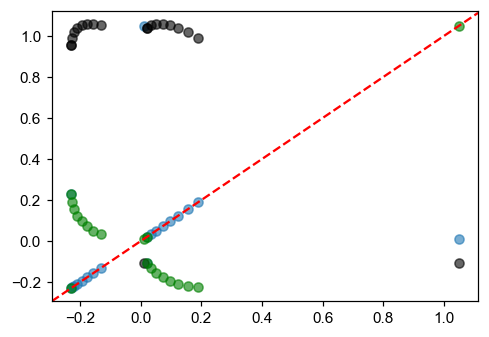

In [233]:
plt.scatter(alpha[iterp1],jk13[:,0],alpha=0.6)
plt.scatter(beta[iterp1],jk13[:,1],alpha=0.6,color='k')
plt.scatter(gamma[iterp1],jk13[:,2],alpha=0.6,color='g')
plt.axline((0,0),(1,1),color='red',ls='--')

In [320]:
# mom[1] = n*mu
mom = deepcopy(momkp1)

# notice the difference in indexing for LHS
momnp1[np.arange(1,n+1)] = jk13[:,0] * mom[np.array(ibis)-1] + jk13[:,1] * mom[np.array(ibis)] + jk13[:,2] * mom[np.array(ibis)+1]

momkp1[iter] = s * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])

In [322]:
print(mom)
print(momkp1)

[ 0.00000000e+00  3.47393282e-07 -2.74700456e-06  9.13676456e-06
 -1.42137300e-05  9.56752223e-06 -8.71191881e-07 -1.33307747e-06
 -6.56337308e-08  1.34241108e-07  6.70000175e-08 -3.22001121e-09
  1.48352614e-09 -3.46108917e-09  2.65250369e-10  1.84175088e-11
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
[ 0.00000000e+00 -1.68969109e-07  2.14661410e-06 -1.12314191e-05
  2.74575538e-05 -3.20712343e-05  1.39560769e-05  2.84388861e-06
 -2.38415376e-06 -8.34192739e-07 -6.62103993e-08  2.68651407e-07
  1.14818048e-07 -4.36374154e-08  1.07681937e-08 -8.43065545e-09
  1.45768421e-09 -2.70206834e-11 -2.61412150e-12  0.00000000e+00
  0.00000000e+00]


array([[ 1.0479249 , -0.10375494,  0.01037549],
       [ 0.02075099,  1.03754941, -0.10375494],
       [ 0.03458498,  1.0513834 , -0.13142292],
       [ 0.05187747,  1.0583004 , -0.15563241],
       [ 0.07262846,  1.0583004 , -0.1763834 ],
       [ 0.09683794,  1.0513834 , -0.19367589],
       [ 0.12450593,  1.03754941, -0.20750988],
       [ 0.15563241,  1.01679842, -0.21788538],
       [ 0.19021739,  0.98913043, -0.22480237],
       [ 0.22826087,  0.95454545, -0.22826087],
       [-0.22826087,  0.95454545,  0.22826087],
       [-0.22480237,  0.98913043,  0.19021739],
       [-0.21788538,  1.01679842,  0.15563241],
       [-0.20750988,  1.03754941,  0.12450593],
       [-0.19367589,  1.0513834 ,  0.09683794],
       [-0.1763834 ,  1.0583004 ,  0.07262846],
       [-0.15563241,  1.0583004 ,  0.05187747],
       [-0.13142292,  1.0513834 ,  0.03458498],
       [-0.10375494,  1.03754941,  0.02075099],
       [ 0.01037549, -0.10375494,  1.0479249 ]])

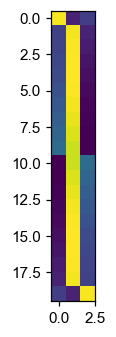

In [306]:
ibis, jk13 = calcJK13(20)
plt.imshow(jk13)
jk13